## Capstone Project : New York City Taxi Fare Prediction
Bhaskar Das
Springboard Data Science Career Track, May 2019 cohort

### Import Libraries

In [1]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Pandas display options

from tqdm import tqdm # Decorate an iterable object. Used for reading large input file

import os # Reading the input files we have access to
import warnings # Ignore warnings
warnings.simplefilter("ignore")

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

### 1. Reading Data

The data contain 55 million rows out of which we will work with only 2 million rows to speed up our model. Later we will use more data to evaluate the accuracy of our model. For the longitude and latitude values, we will use float32 insted of float64 to train data faster. While reading the data, we will treat the variable "pickup_datetime" as a date and drop the variable "key" since it is a unique identifier.

In [2]:
%%time

TRAIN_PATH = './input/train.csv'

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32', #'key':'object', # dropped ID variable
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

chunksize = 2_000_000

df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    # Using parse_dates would be much slower
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
    
# Merge all dataframes into one dataframe
train_df_all = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# Use only chunksize (2 million) data sets for training
train_df = train_df_all.head(chunksize)    

# Delete train_df_all which contain all 55 million rows
del train_df_all

train_df.head()

28it [01:48,  3.87s/it]


Wall time: 1min 50s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1


In [3]:
# check statistics of the features
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2000000.000,2000000.000,2000000.000,1999986.000,1999986.000,2000000.000
mean,11.348,-72.523,39.930,-72.524,39.928,1.684
std,9.853,12.868,7.983,12.775,10.324,1.315
min,-62.000,-3377.681,-3458.665,-3383.297,-3461.541,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,2856.442,2621.628,3414.307,3345.917,208.000


We can observe that there are a number of outliers present in the data:

- fare_amount contains negative value.
- the latitude and longitude values.
- passenger_count contains 0 value.

### 2. Missing value treatment

We will remove observations with missing entries.

In [4]:
# Check missing values
print(train_df.isnull().sum())

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


Only two columns contains missing values and we have deleted those rows.

In [5]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna()
#train_df = train_df[train_df.fare_amount>=0]
print('New size: %d\n' % len(train_df))

# Check missing values
print(train_df.isnull().sum())
#train_df.info()

Old size: 2000000
New size: 1999986

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### 3. Outlier Detection and Treatment

#### Fare Amount

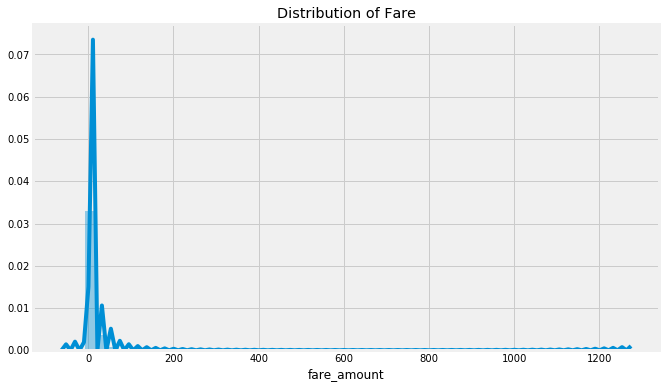

In [6]:
# Examine the Target Variable
plt.figure(figsize = (10, 6))
sns.distplot(train_df['fare_amount']);
plt.title('Distribution of Fare');

In [7]:
print("Negative fares: ", len(train_df[train_df['fare_amount'] < 0]))
print("$0 fares: ", len(train_df[train_df['fare_amount'] == 0]))
print("Less than minimum $2.5 fares: ", len(train_df[train_df['fare_amount'] < 2.5]))
print("Fares between $2.5 and $100: ", len(train_df[train_df['fare_amount'].between(left=2.5,right=100)]))
print("Fares greater than $100: ", len(train_df[train_df['fare_amount'] > 100]))

Negative fares:  77
$0 fares:  56
Less than minimum $2.5 fares:  155
Fares between $2.5 and $100:  1999046
Fares greater than $100:  785


Most of the rides lies between \\$2.5 and \\$100. 

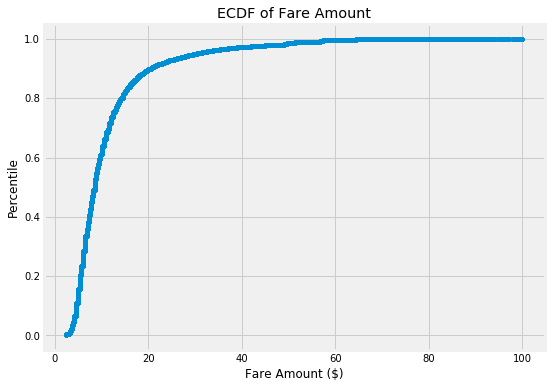

In [8]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

fare_100 = train_df[train_df['fare_amount'].between(left=2.5,right=100)]

xs, ys = ecdf(fare_100['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

From the ECDF plot, we can observe that most of the rides are below \\$20. Next, we will remove fares less than \\$2.5, which is the minimum fare, and greater than \\$100.

In [9]:
print('Old size: %d' % len(train_df))

# Remove fare < $2.5
train_df = train_df.drop(train_df[train_df['fare_amount']<2.5].index, axis=0)
# Remove fare > $100
train_df = train_df.drop(train_df[train_df['fare_amount']>100.0].index, axis=0)

print('New size: %d' % len(train_df))

#no more negative values in the fare field
print(train_df['fare_amount'].describe())

Old size: 1999986
New size: 1999046
count   1999046.000
mean         11.297
std           9.415
min           2.500
25%           6.000
50%           8.500
75%          12.500
max         100.000
Name: fare_amount, dtype: float64


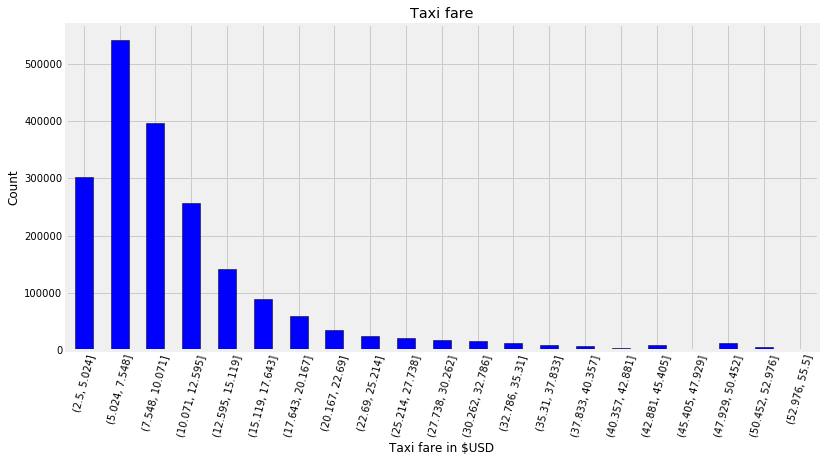

In [10]:
# Fare into a separate dataframe
fare_data = train_df[['fare_amount']]

# Bin the age data
fare_data['fare_bin'] = pd.cut(train_df['fare_amount'], bins = np.linspace(2.5, 55.5, num = 22))

plt.figure(figsize = (12, 6))

# Graph the fare bins as a bar plot
fare_data['fare_bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Taxi fare in $USD'); plt.ylabel('Count')
plt.title('Taxi fare');

The minimum taxi fares in New York City starts from \\$2.5. Therefore, all the records having values less than \\$2.50 are removed. 

#### Passenger Counts

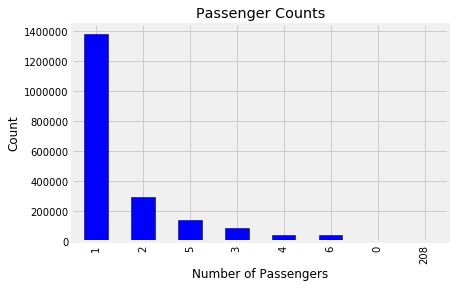

In [11]:
train_df['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

We will assume that the taxi is a sedan and can accomodate at most 5 passengers. Therefore, all recordes will be deleted where passenger counts is more than 5. Also, we will assume that a taxi should have at least 1 passenger.

In [12]:
print('Old size: %d' % len(train_df))
# remove passenger count > 5
train_df = train_df.loc[train_df['passenger_count'] < 6]
# remove records with passenger count == 0
train_df = train_df.loc[train_df['passenger_count'] > 0]
print('New size: %d' % len(train_df))

Old size: 1999046
New size: 1949939


#### Location Data

The location data contains two variables latitude and longitude. We will find the 2.5% and 97.5% percentile values of the latitude and longitude columns to remove the outliers. 

In [13]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(train_df[col], 2.5), 2):5} \t 97.5% = \
    {round(np.percentile(train_df[col], 97.5), 2)}')
    
print('Old size: %d' % len(train_df))
# Remove latitude and longtiude outliers
train_df = train_df.loc[train_df['pickup_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['pickup_longitude'].between(-75, -72)]
train_df = train_df.loc[train_df['dropoff_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['dropoff_longitude'].between(-75, -72)]

print('New size: %d' % len(train_df))

Pickup_latitude  : 2.5% = 40.64 	 97.5% =     40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% =     -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% =     40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% =     -73.78
Old size: 1949939
New size: 1909426


### 4. Exploratory Data Analysis (EDA)

We will use visualization methods to find trends, anomalies, patterns, or relationships within the data. EDA helps us to learn more about our data.

#### Relationship between number of passengers and fare

Text(0, 0.5, 'Frequency')

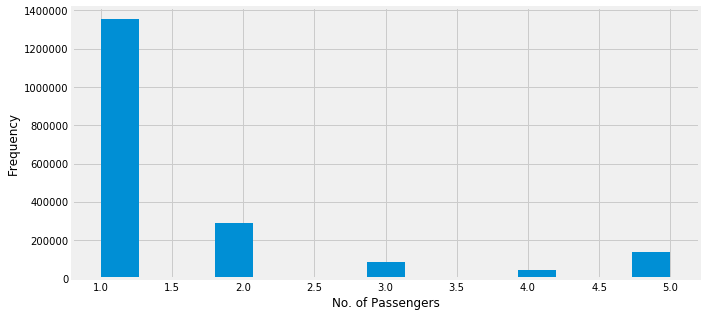

In [14]:
plt.figure(figsize=(10,5))
plt.hist(train_df['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Single passengers are the most frequent travellers.

Text(0, 0.5, 'Fare')

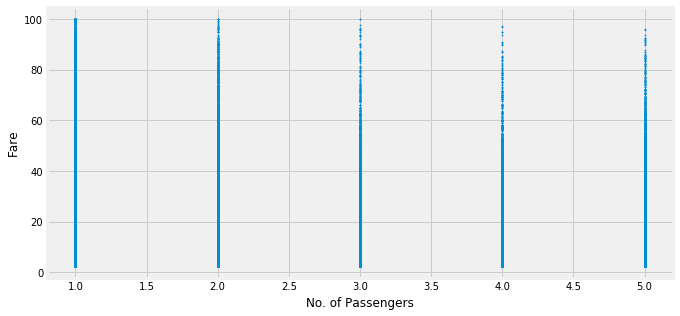

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

The cabs receive heighest fares when thay carry single passengers.

### 4. Feature Engineering

We will create new features from the input data to build an accurate machine learning model. The first feature we will create is the distance. We will compute the distance from the pickup and dropoff latitudes and longitudes values by using the Haversine formula. We will add this new distance feature in our data.

In [16]:
def haversine_distance(df, lat1, long1, lat2, long2):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    df['distance'] = d
    #return d

haversine_distance(train_df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999


In [17]:
datat=train_df.copy()
datat2=datat.loc[:, ['fare_amount', 'passenger_count', 'distance']].sort_values(by=['distance'])
datat2.iloc[500000:500020,:]

,fare_amount,passenger_count,distance
1863726,10.100,1,1.290
1713312,5.700,1,1.290
1567227,7.500,1,1.290
1049566,6.100,3,1.290
929582,5.500,1,1.290
1615313,6.500,1,1.290
1437309,6.000,1,1.290
584499,9.000,1,1.290
584085,4.500,1,1.290
1469833,6.000,1,1.290


From our observation, it looks like the 'passenger_count' does not have an impact on the 'fare_amount' when the distance is constant. For instance, both index 960389 and 95391 shows the same fare \\$8.0 for a traveling distance of 1.290km while the number of passengers differs. __Therefore, we will remove 'passenger_count' column from our machine learning model.__ 

We will create the new features, year, month, date, hour, and day_of_week from the pickup_datetime variable.

In [18]:
train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['date'] = train_df['pickup_datetime'].dt.day
train_df['wk'] = train_df['pickup_datetime'].dt.day_name()
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7


Remove 'pickup_datetime' column.

We have created a new feature 'dt' from the 'hour' variable. The new variable 'dt' consists of four values, 'Morning', 'Afternoon', 'Evening', or 'Night'.  From 6 to 11 am is ‘Morning’. 'Afternoon' represents the value between 12 noon to 5 pm. 'Evening' represents the hour value between 6 pm to 11 pm, and 'Night' represents the rest of the hour values. Later, we remove the 'hour' variable.

In [19]:
def hourtime(hval):
    if hval>=6 and hval<=11:
        return  'Morning'
    if hval>=12 and hval<=17:
        return  'Afternoon'
    if hval>=18 and hval<=23:
        return  'Evening'
    if hval>=0 and hval<=5:
        return  'Night'

train_df['dt'] = train_df['hour'].apply(hourtime)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning


We have added the month name as a new variable 'mn' based on the numeric value from the 'month' variable and then deleted the 'month'.

In [20]:
def monthnm(i):
    switcher={
        1:'January',
        2:'February', 
        3:'March', 
        4:'April', 
        5:'May', 
        6:'June', 
        7:'July', 
        8:'August', 
        9:'September', 
        10:'October', 
        11:'November', 
        12:'December'
    }
    return switcher.get(i)
        
train_df['mn'] = train_df['month'].apply(monthnm)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March


#### Relative distances in Latitude and Longitude is calculated and added as new columns.
We have calculated the relative distances from the pickup and dropoff latitude and longitude values and added as new columns.

In [21]:
train_df['lat_diff'] = (train_df['dropoff_latitude'] - train_df['pickup_latitude']).abs()
train_df['lon_diff'] = (train_df['dropoff_longitude'] - train_df['pickup_longitude']).abs()
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June,0.009,0.003
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January,0.071,0.037
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August,0.011,0.009
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April,0.025,0.004
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March,0.016,0.011


#### Effect of the date and time of pickup on the fare

Text(0.5, 1.0, 'Effect of the date of pickup on the frequency of ride')

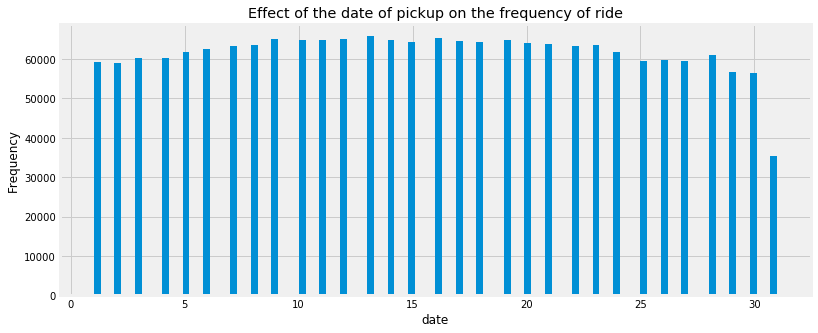

In [22]:
plt.figure(figsize=(12,5))
plt.hist(train_df['date'], bins=100)
plt.xlabel('date')
plt.ylabel('Frequency')
plt.title('Effect of the date of pickup on the frequency of ride')

Text(0.5, 1.0, 'Effect of the date of pickup on the fare')

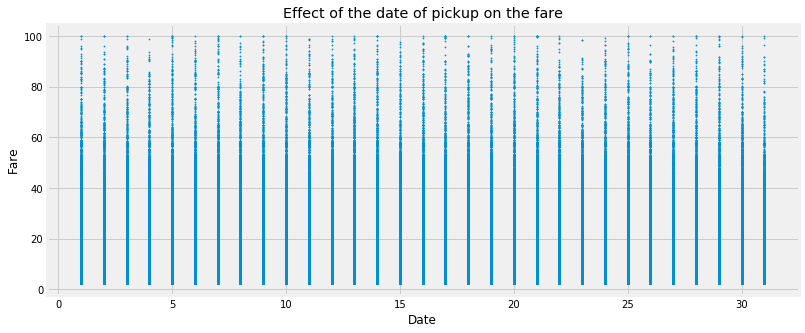

In [23]:
plt.figure(figsize=(12,5))
plt.scatter(x=train_df['date'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Fare')
plt.title('Effect of the date of pickup on the fare')

From the above figures, it looks like the frequency of ride and the fare are not affected by the date.

Text(0.5, 1.0, 'Time of the day and the frequency of ride')

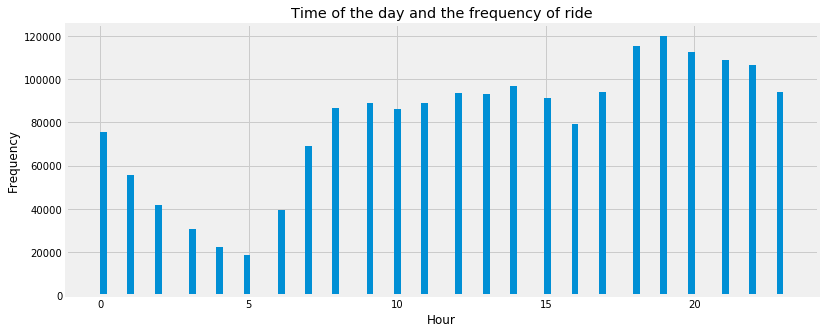

In [24]:
plt.figure(figsize=(12,5))
plt.hist(train_df['hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Time of the day and the frequency of ride')

The time of the day affects the frequency of the rides. Morning 5 sees the lowest and evening 7 being the highest.

Text(0.5, 1.0, 'Effect of the time of the day on the fare')

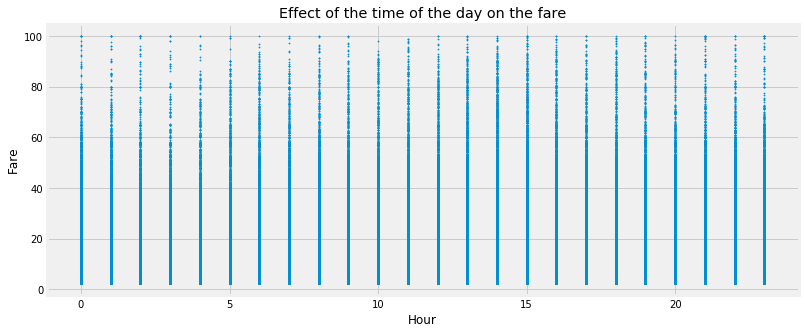

In [25]:
plt.figure(figsize=(12,5))
plt.scatter(x=train_df['hour'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.title('Effect of the time of the day on the fare')

However, the fare is high between 5 AM to 9 AM and 1 PM to 4 PM.

Text(0.5, 1.0, 'Time of the day and the the frequency of ride')

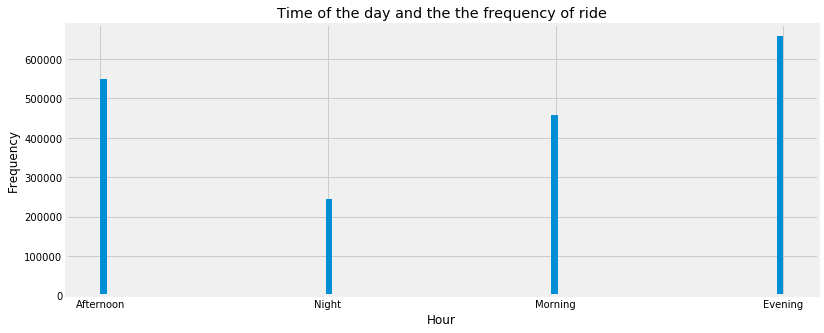

In [26]:
plt.figure(figsize=(12,5))
plt.hist(train_df['dt'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Time of the day and the the frequency of ride')

Rides increase in the evening and decrease at night.

Text(0.5, 1.0, 'Effect of the time of the day on the fare')

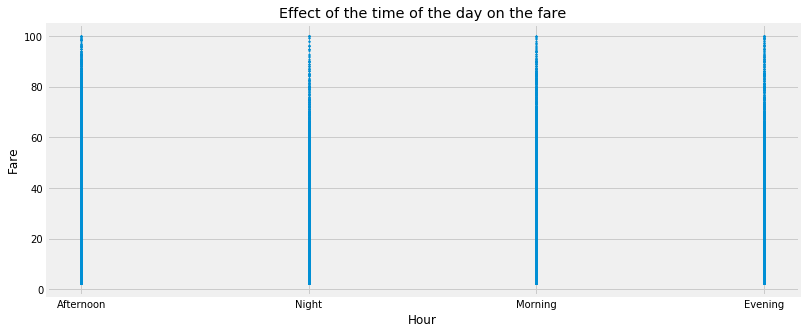

In [27]:
plt.figure(figsize=(12,5))
plt.scatter(x=train_df['dt'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.title('Effect of the time of the day on the fare')

#### Effect of the day of the week on the fare

Text(0.5, 1.0, 'Day of the week and the frequency of ride')

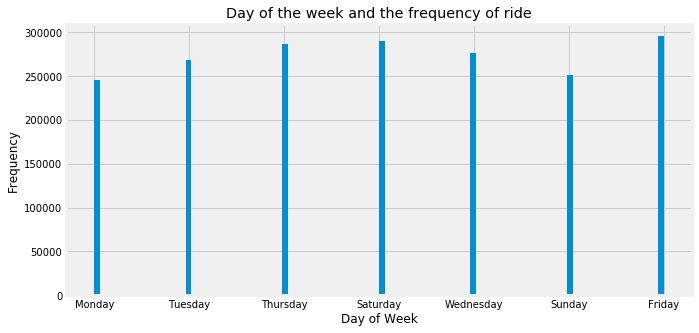

In [28]:
plt.figure(figsize=(10,5))
plt.hist(train_df['wk'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.title('Day of the week and the frequency of ride')

The day of the week doesn't seem to have much of an influence on the number of taxi rides. However, the frequency of rides increases on Thursday and decreases on Sunday and Monday.

Text(0.5, 1.0, 'Day of the week and the fare of ride')

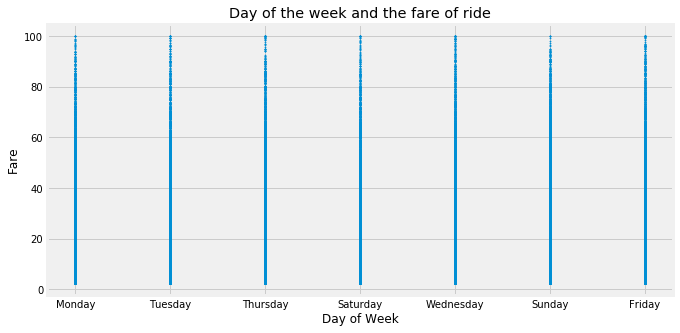

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['wk'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Day of Week')
plt.ylabel('Fare')
plt.title('Day of the week and the fare of ride')

The day of the week doesn't seem to have much of an influence on the fare of a rides.

#### Effect of the month on the fare

Text(0.5, 1.0, 'Month and the frequency of ride')

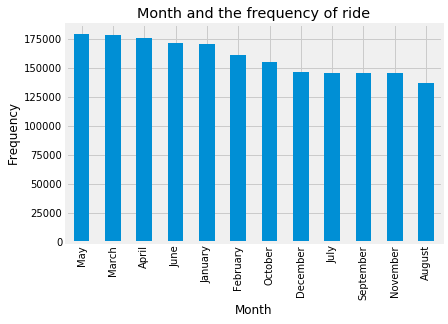

In [30]:
train_df['mn'].value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Month and the frequency of ride')

The first half of the year observed more rides than the second half of the year.

#### Effect of the distance on the fare

In [31]:
from collections import Counter

train_df_dist = train_df.sort_values(['distance','fare_amount'], ascending=False)

bins_0 = train_df_dist.loc[(train_df_dist['distance'] == 0), ['distance']]
bins_1 = train_df_dist.loc[(train_df_dist['distance'] > 0) & (train_df_dist['distance'] <= 10),['distance']]
bins_2 = train_df_dist.loc[(train_df_dist['distance'] > 10) & (train_df_dist['distance'] <= 50),['distance']]
bins_3 = train_df_dist.loc[(train_df_dist['distance'] > 50) & (train_df_dist['distance'] <= 100),['distance']]
bins_4 = train_df_dist.loc[(train_df_dist['distance'] > 100),['distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '>100'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4])

Counter(dist_bins['bins'])

Counter({'0': 20757,
         '0-10': 1793034,
         '11-50': 95282,
         '51-100': 277,
         '>100': 76})

Text(0, 0.5, 'Frequency')

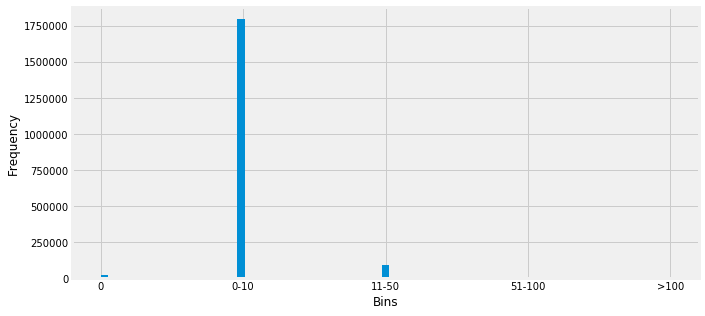

In [32]:
plt.figure(figsize=(10,5))
plt.hist(dist_bins['bins'], bins=75)
plt.xlabel('Bins')
plt.ylabel('Frequency')

We will delete all records where distance is 0 km, but the fare amount is not $0.

In [33]:
# Delete all records where distance is 0
train_df.drop(train_df.loc[train_df['distance']==0].index, inplace=True)
print(train_df.shape)
train_df.loc[(train_df['distance']==0)]

(1888669, 17)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff


#### Encoding categorical variables

We have encoded the following variables with one-hot encoding.

- 'date': The date variable does not show any change in the fare. Therefore, we have encoded it. 
- 'year': The year variable does not show any difference in the fare based on the increase or decrease in the year.
- 'passenger_count': The fare remains unaffected by the number of passengers riding in a taxi.
- The object type variables, such as the month, week, and time of the day are also encoded.

In [34]:
def datestr(dval):
    return str(int(dval))
def yrstr(yval):
    return str(int(yval))
def pcstr(pval):
    return str(int(pval))

train_df['dd'] = train_df['date'].apply(datestr)
train_df['yr'] = train_df['year'].apply(yrstr)
train_df['pc'] = train_df['passenger_count'].apply(pcstr)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,wk,hour,dt,mn,lat_diff,lon_diff,dd,yr,pc
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,Monday,17,Afternoon,June,0.009,0.003,15,2009,1
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,Tuesday,16,Afternoon,January,0.071,0.037,5,2010,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,Thursday,0,Night,August,0.011,0.009,18,2011,2
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,Saturday,4,Night,April,0.025,0.004,21,2012,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,Tuesday,7,Morning,March,0.016,0.011,9,2010,1


In [35]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    
# Categorical features with One-Hot encode
train_df, cat_cols = one_hot_encoder(train_df)   

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,...,0,0,0,0,0,1,0,0,0,0
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,...,0,0,0,0,0,1,0,0,0,0
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,...,1,0,0,0,0,0,1,0,0,0
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,...,0,1,0,0,0,1,0,0,0,0
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,...,0,0,0,0,0,1,0,0,0,0


We will remove columns those are not required.

In [36]:
# Backup data
train_df6_drop=train_df.copy()
train_df6_drop1=train_df.copy()
train_df6_drop2=train_df.copy()

In [37]:
train_df6_drop1.drop(['month', 'hour', 'year', 'date', 'pickup_datetime', 'passenger_count',\
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance'],\
                      axis=1, inplace=True)
train_df6_drop2.drop(['month', 'hour', 'year', 'date', 'pickup_datetime', 'passenger_count',\
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'lat_diff', \
                     'lon_diff'], axis=1, inplace=True)

### 5. Machine Learning

In [38]:
# data backup
train_df7 = train_df.copy()
df1=train_df6_drop1.copy()
df2=train_df6_drop2.copy()

In [39]:
# We will use lat_diff lon_diff features instead of distance for better accuracy
train_df=df1.copy() # lat lon diff
# train_df=df2.copy() # distance

In [40]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

labels = train_df['fare_amount']
df = train_df.drop('fare_amount', axis=1)

# train_test_split
trainx, testx, trainy, testy = train_test_split(df, labels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 68) (566601, 68) (1322068,) (566601,)


Root mean squared error and Mean absolute percentage error will be used for model evaluation.

In [41]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

__Linear Regression:__

In [42]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(trainx, trainy)
evaluate(lr, list(df.columns), trainx, testx, trainy, testy)

Training:   rmse = 5.099999904632568 	 mape = 25.97
Validation: rmse = 5.070000171661377 	 mape = 26.01


__Light Gradient Boosting__

Training:   rmse = 3.64 	 mape = 18.88
Validation: rmse = 3.67 	 mape = 18.97


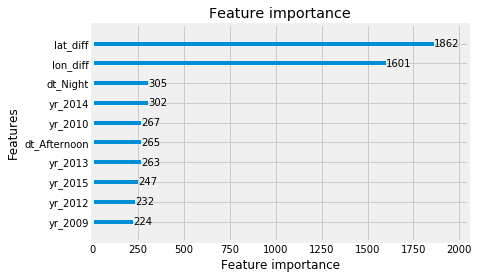

In [43]:
import lightgbm as lgbm

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

# pred_test_y = np.zeros(testx.shape[0])
# print(pred_test_y.shape)
train_set = lgbm.Dataset(trainx, trainy, silent=True)
# print(train_set)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
# print(model)
# pred_test_y = model.predict(testx, num_iteration = model.best_iteration)
# print(pred_test_y)

evaluate(model, list(df.columns), trainx, testx, trainy, testy)

ax = lgbm.plot_importance(model, max_num_features=10)
plt.show()

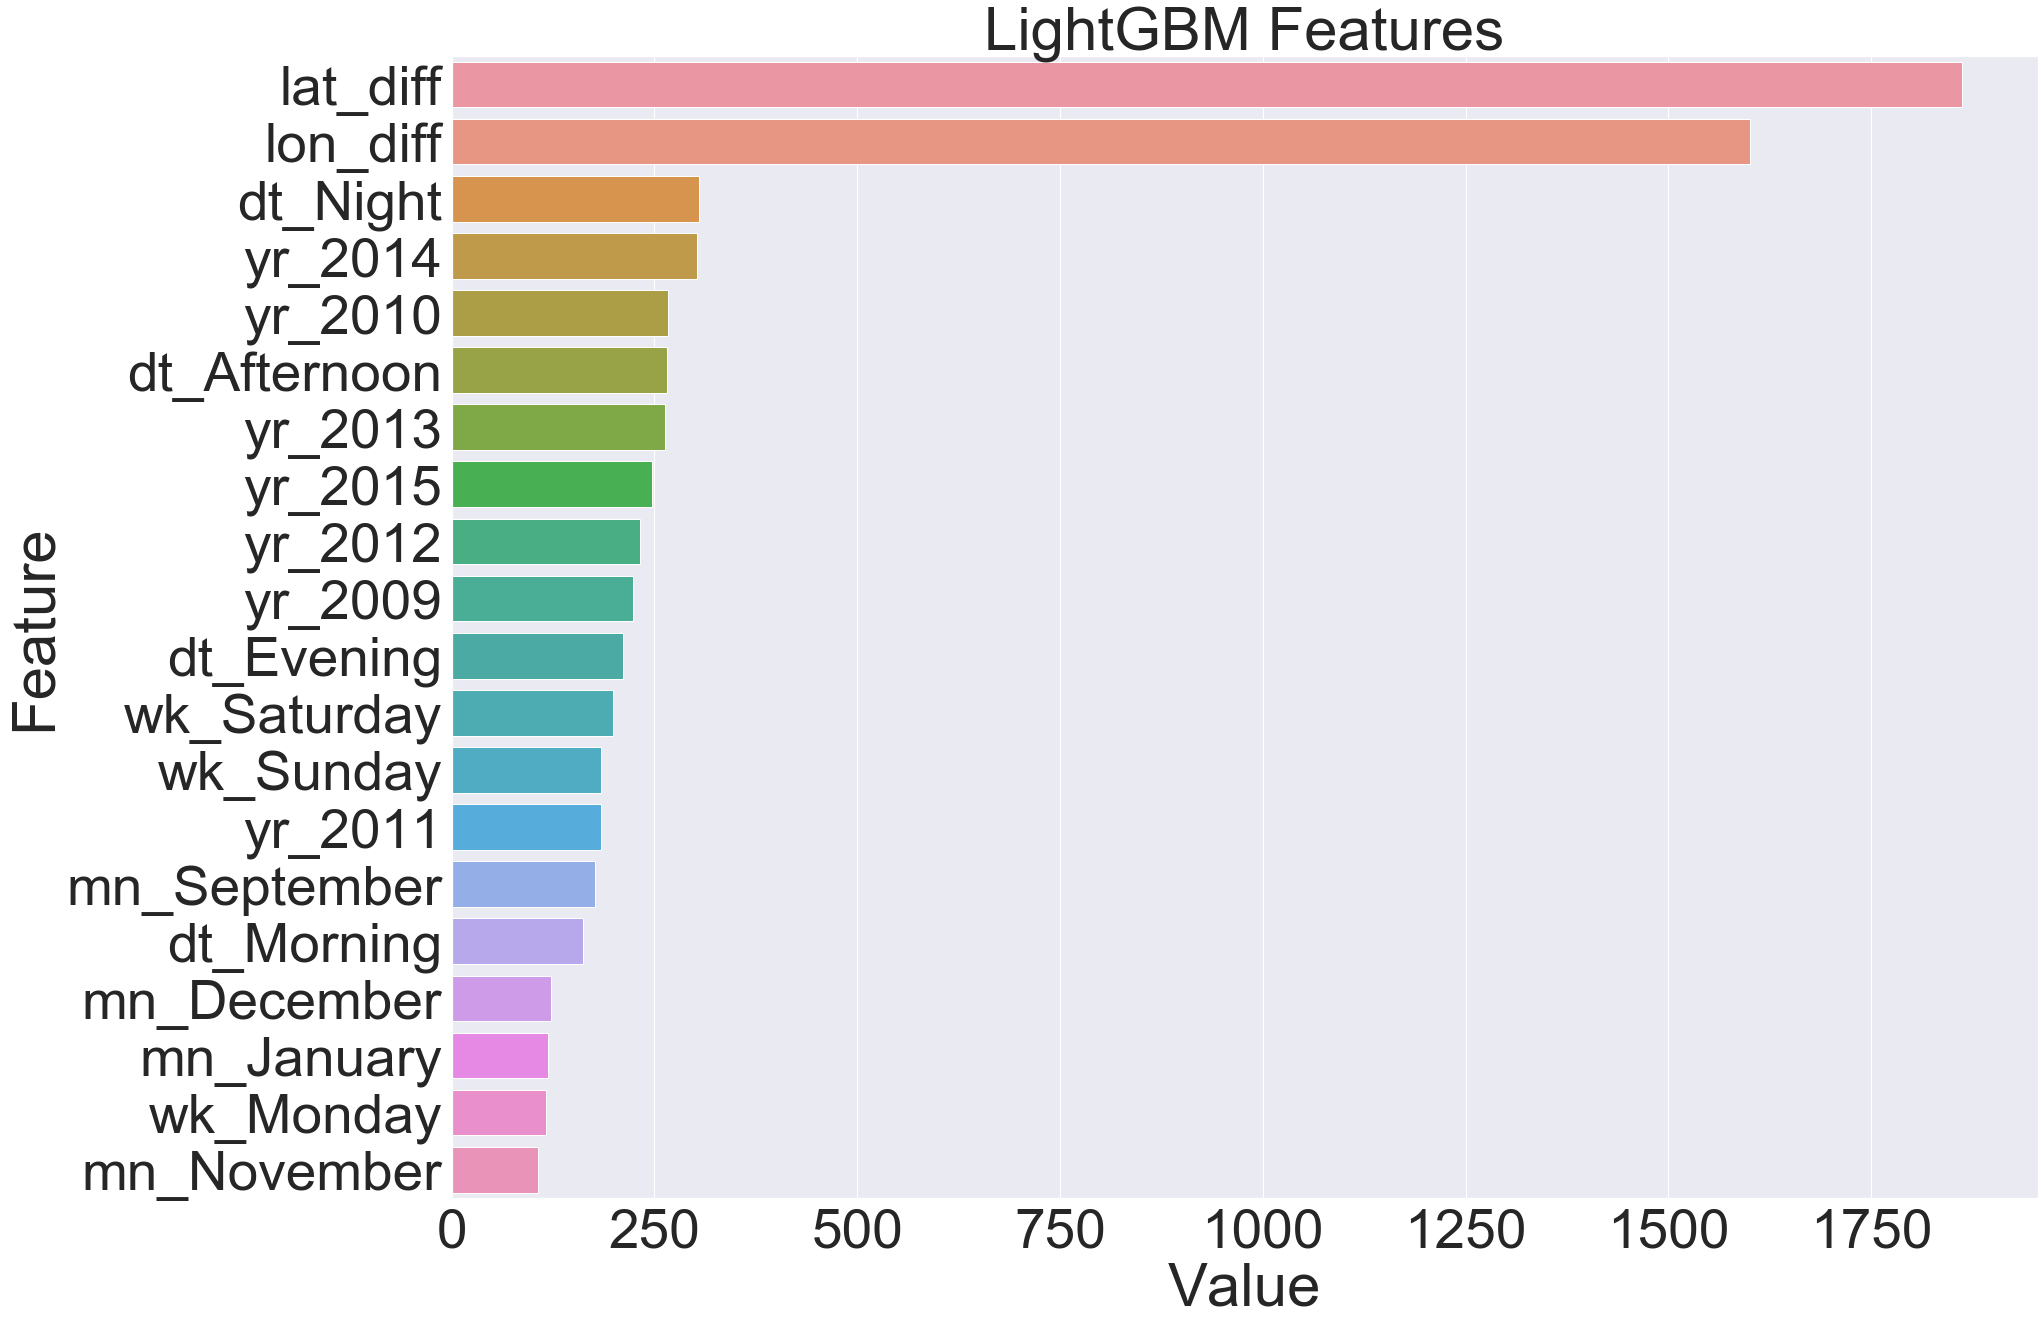

In [44]:
#feature_imp = pd.DataFrame(sorted(zip(model.feature_importance,df.columns)), columns=['Value','Feature'])
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':df.columns})
#plt.figure(figsize=(20, 10))
#sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
#plt.title('LightGBM Features')
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(30, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### Multicollinearity

In [45]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Parameter tuning for light gbm model using GridSearchCV

In [46]:
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

estimator = lgbm.LGBMRegressor()#num_leaves=31)

param_grid = {
    'learning_rate': [0.05, 0.01], #0.001, 0.005, 
    'num_leaves': [15,25],
    'max_depth': [5, 6]#, #, 8, 10
    #'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(trainx, trainy)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 25}


In [47]:
%%time

import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

trainx=pd.read_csv('multicollinearity_latlondiff_df.csv')
estimator = lgbm.LGBMRegressor()

param_grid = {
    'learning_rate': [0.001, 0.005, 0.05], # 
    'num_leaves': [15, 20, 25, 31],
    'max_depth': [5, 6, 7, 8]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(trainx, trainy)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 31}
Wall time: 15min 26s


## Multicollinearity Analysis with lat_lon_diff

In [49]:
mcdf = pd.read_csv('lat_lon_diff_df.csv')
ylabels=mcdf['fare_amount']
mcdf = mcdf.iloc[:,2:]
print(ylabels.head())
mcdf.head()

0    4.500
1   16.900
2    5.700
3    7.700
4    5.300
Name: fare_amount, dtype: float64


,lat_diff,lon_diff,wk_Friday,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Afternoon,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,0.009,0.003,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.071,0.037,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.011,0.009,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.025,0.004,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.016,0.011,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [50]:
%%time

def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)

mcdf_nd = mcdf._get_numeric_data()
mc_df, mc_vif = iterate_vif(mcdf_nd)

Iteration # 1
Removing wk_Friday with VIF of inf
Iteration # 2
Removing dt_Afternoon with VIF of inf
Iteration # 3
Removing mn_April with VIF of inf
Iteration # 4
Removing dd_1 with VIF of inf
Iteration # 5
Removing yr_2009 with VIF of inf
Iteration # 6
Removing pc_1 with VIF of 40.600000
Iteration # 7
Complete
Wall time: 1h 59min 54s


In [51]:
mc_df.to_csv('multicollinearity_latlondiff_data.csv')
mc_vif.to_csv('multicollinearity_df_latlondiff_vif_data.csv')

In [52]:
# train_test_split
trainx, testx, trainy, testy = train_test_split(mc_df, ylabels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 62) (566601, 62) (1322068,) (566601,)


In [82]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': 10,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

train_set = lgbm.Dataset(trainx, trainy, silent=True)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)

evaluate(model, list(trainx.columns), trainx, testx, trainy, testy)

Training:   rmse = 3.6 	 mape = 18.78
Validation: rmse = 3.67 	 mape = 18.93


<Figure size 2160x1440 with 0 Axes>

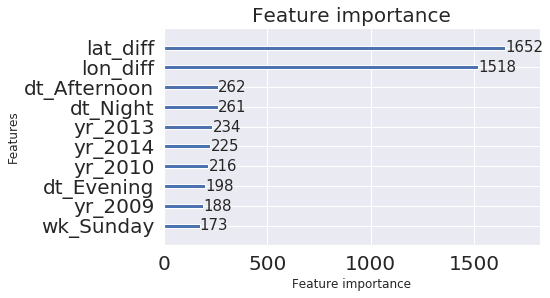

In [83]:
plt.figure(figsize=(30, 20))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

SMALL_SIZE = 20
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('font', **font)
lgbm.plot_importance(model, max_num_features=10)
plt.show()

In [54]:
import lightgbm as lgb

lgb_train = lgb.Dataset(trainx, trainy, free_raw_data=False)
lgb_val = lgb.Dataset(testx, testy, reference=lgb_train, free_raw_data=False)

core_params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 10,
    'nthread': 4,
    'verbose': 0,
    'metric': 'rmse'
}

training_set = lgb.Dataset(trainx, trainy, silent=True)
boost_rounds=300
early_stopping_rounds=500
validation_set=ylabels

evals_result = {}
gbm = lgb.train(core_params, # parameter dict to use
                train_set = lgb_train,
                num_boost_round=boost_rounds, # number of boosting rounds.
                early_stopping_rounds=early_stopping_rounds,
                valid_sets=lgb_val,
                evals_result=evals_result, # stores validation results.
                verbose_eval=False) # print evaluations during training.

evaluate(gbm, list(trainx.columns), trainx, testx, trainy, testy)


Training:   rmse = 3.59 	 mape = 18.52
Validation: rmse = 3.65 	 mape = 18.67


In [55]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(trainx, trainy)
evaluate(random_forest, list(trainx.columns), trainx, testx, trainy, testy)
trainx.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.8s finished


Training:   rmse = 2.63 	 mape = 16.25
Validation: rmse = 3.74 	 mape = 19.07


,lat_diff,lon_diff,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Evening,dt_Morning,...,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_2,pc_3,pc_4,pc_5
1818302,0.043,0.023,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1818588,0.077,0.060,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1345055,0.010,0.012,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
461281,0.012,0.007,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1793270,0.033,0.185,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [84]:
import xgboost as xgb3

data_dmatrix = xgb3.DMatrix(data=mcdf,label=ylabels)

xg_reg3 = xgb3.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

xg_reg3.fit(trainx,trainy)

preds = xg_reg3.predict(testx)

rmse = np.sqrt(mean_squared_error(testy, preds))
print("RMSE: %f" % (rmse))

evaluate(xg_reg3, list(trainx.columns), trainx, testx, trainy, testy)

[10:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 8.582098
Training:   rmse = 8.63 	 mape = 31.35
Validation: rmse = 8.58 	 mape = 31.36


<Figure size 2160x1440 with 0 Axes>

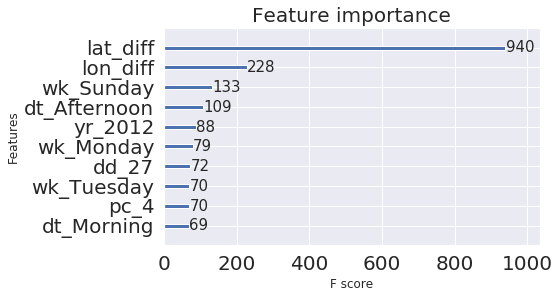

In [85]:
plt.figure(figsize=(30, 20))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

SMALL_SIZE = 20
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('font', **font)
xgb3.plot_importance(xg_reg3, max_num_features=10)
plt.show()

## Model without Multicolinearity

In [57]:
df_all = pd.read_csv('lat_lon_diff_df.csv')
y=df_all['fare_amount']
df = df_all.iloc[:,2:]
print(y.head())
df.head()

0    4.500
1   16.900
2    5.700
3    7.700
4    5.300
Name: fare_amount, dtype: float64


,lat_diff,lon_diff,wk_Friday,wk_Monday,wk_Saturday,wk_Sunday,wk_Thursday,wk_Tuesday,wk_Wednesday,dt_Afternoon,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,pc_1,pc_2,pc_3,pc_4,pc_5
0,0.009,0.003,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.071,0.037,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.011,0.009,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.025,0.004,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.016,0.011,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [58]:
# train_test_split
trainx, testx, trainy, testy = train_test_split(df, y, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1322068, 68) (566601, 68) (1322068,) (566601,)


In [67]:
# Create the random forest
random_forest = RandomForestRegressor(max_depth = 10, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(trainx, trainy)
evaluate(random_forest, list(trainx.columns), trainx, testx, trainy, testy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


Training:   rmse = 3.68 	 mape = 19.85
Validation: rmse = 3.75 	 mape = 19.98
